# Seguimiento

Alejandro Jesús González Santana

## Hipótesis:

Realizar el seguimiento de la mano de una persona a lo largo de un vídeo con los siguientes métodos:

- YOLO
- Farneback
- Lucas-Kanade
- RAFT

## YOLO

Para ejecutar YOLO, es necesario descargar la librería de Ultralytics e importar el modelo correspondiente. Para utilizar YOLO, también se debe cargar un modelo preentrenado. En clase, se recomendó usar el modelo yolov8x-pose-p6.pt, que está diseñado para la detección de poses humanas.

La primera función definida en el código tiene como objetivo filtrar los puntos entrantes en función del último punto registrado en nuestra lista. El filtro se aplica comparando la distancia entre el punto actual y el último punto registrado. Si se detecta que la posición en el eje x se desplaza más de 100 píxeles con respecto al último punto, o si la posición en el eje y también varía de manera similar, se descarta el nuevo punto, ya que se asume que pertenece a una entidad diferente.

Para realizar el seguimiento en tiempo real mientras se ejecuta el modelo, se crea una imagen en negro con el mismo tamaño que el primer frame del video. También se inicializan las listas x e y para almacenar las posiciones, lo cual es necesario para poder comparar la posición de la entidad con otros métodos. Mientras la variable status sea verdadera, se continuará obteniendo los resultados del modelo YOLO para el frame actual del video. La lista results[0] contiene las predicciones de detección de personas en la imagen. Recorremos esta lista para obtener los keypoints de cada persona, en particular, nos interesa acceder a la posición 11, que corresponde a la predicción de la muñeca derecha.

Es necesario verificar que las coordenadas  x e y de la muñeca estén presentes. Si la lista de coordenadas (por ejemplo, comparando con x, aunque también podría hacerse con la lista de  y) está vacía, no se agrega el punto. Si ambas condiciones se cumplen, se añaden las coordenadas x e y de la muñeca a las listas x e y, y luego se pasa al siguiente frame.

Una vez que tenemos un punto agregado, se verifica si la mano detectada pertenece a la misma entidad usando la función check_distance. Si es así, se agrega a la lista de seguimiento. En cada frame, el punto se marca con un círculo, y durante el seguimiento se actualizan las posiciones de la mano detectada, representándolas también con círculos.

Si un punto no se agrega en una iteración, no se actualiza la variable lastframe con el valor de recorridos_yolo. Esta variable permite controlar que el la mano no se haya detectado durante algunos frames. Como norma la mano se pierde si tras cinco frames no se ha agregado nada a la lista.Esto cambiaría la variable status a False y terminaría la lectura del vídeo.

Si un punto no se agrega durante una iteración, la variable lastf_rame no se actualiza con el valor de recorridos_yolo. Esta variable se utiliza para controlar si la mano no ha sido detectada durante varios frames consecutivos. Según la lógica del sistema, se considera que la mano se ha perdido si no se ha agregado ningún punto a la lista durante cinco frames consecutivos. En ese caso, la variable status se cambia a False, lo que finaliza la lectura del video.

In [1]:
# Procesar imágenes de un vídeo o de la webcam
import numpy as np
import torch
import cv2 as cv
from torchvision.models import detection
from ultralytics import YOLO

def check_distance(x, y, x_list, y_list):
    if (abs(x - x_list[-1]) < 100 and abs(y - y_list[-1]) < 100):
        return True
    else:
        return False


#model = YOLO("yolo11x-pose.pt")
model = YOLO("yolov8x-pose-p6.pt")
model.to('cuda')
video = cv.VideoCapture("Videos-20241121/people2.mp4")

status, img = video.read()

tracking = 255*np.ones((img.shape[0], img.shape[1], 3))

pos = 10
x_yolo = []
y_yolo = []

recorridos_yolo = 0
last_frame = 0


while status:
    recorridos_yolo += 1
    results = model(img)

    for i in range(len(results[0])):
        result = results[0]

        x_right = int(result.keypoints.data[i][10][0])
        y_right = int(result.keypoints.data[i][10][1])

        if x_right and y_right  and len(x_yolo)==0:
            cv.circle(img, (x_right, y_right), 2, (0, 0, 255), -1)
            cv.circle(tracking, (x_right, y_right), 2, (0, 0, 255), -1)
            x_yolo.append(x_right)
            y_yolo.append(y_right)
            break
        
        elif len(x_yolo)>=1:
            if check_distance(x_right, y_right, x_yolo, y_yolo):
                cv.circle(img, (x_right, y_right), 2, (0, 0, 255), -1)
                cv.circle(tracking, (x_right, y_right), 2, (0, 0, 255), -1)
                x_yolo.append(x_right)
                y_yolo.append(y_right)
                last_frame = recorridos_yolo
                break
    
    #cv.imshow('Output', img)
    #cv.imshow('Tracking', tracking)

    if recorridos_yolo - last_frame > 5:
        status = False
        print('Persona no encontrada')

    else:
        status, img = video.read()
    
    #if cv.waitKey(1)==27:
        #status = False

video.release()
#cv.destroyAllWindows()


0: 768x1280 27 persons, 451.0ms
Speed: 8.9ms preprocess, 451.0ms inference, 422.1ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 22 persons, 420.0ms
Speed: 12.9ms preprocess, 420.0ms inference, 38.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 23 persons, 419.0ms
Speed: 9.0ms preprocess, 419.0ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 23 persons, 420.0ms
Speed: 12.0ms preprocess, 420.0ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 26 persons, 420.3ms
Speed: 12.0ms preprocess, 420.3ms inference, 5.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 22 persons, 423.3ms
Speed: 10.0ms preprocess, 423.3ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 20 persons, 424.7ms
Speed: 14.0ms preprocess, 424.7ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1280)

0: 768x1280 23 persons, 512.8ms
Speed: 8.6ms preprocess, 512.8ms in

Otra de las cosas que necesitamos hacer es calcular la velocidad estimada de la persona a lo largo del vídeo. Esto se calcula como la raíz cuadrada de la suma de las derivadas al cuadrado de las coordenadas x e y, que representan el movimiento de la persona en cada fotograma.

In [2]:
vx_yolo = np.diff(x_yolo)
vy_yolo = np.diff(y_yolo)

velocidad_yolo = np.sqrt(vx_yolo**2 + vy_yolo**2)

## Farneback

El siguiente código implementa la predicción de la posición de la mano utilizando el método de Farneback (flujo óptico), basándose en un primer punto obtenido con YOLO. La principal diferencia con el enfoque anterior es que, durante la lectura del video, solo se aplica YOLO mientras no haya posiciones en la lista x de Farneback. Una vez que YOLO detecta el primer punto y agrega sus coordenadas a las listas, el frame actual se guarda como el frame previo. El método de Farneback estima el flujo óptico calculando el movimiento de los píxeles entre dos imágenes consecutivas, por lo que es necesario contar con el frame previo en cada iteración.

Una vez que se ha agregado un punto, y mientras no se hayan recorrido más frames que con YOLO, se calcula el flujo óptico utilizando Farneback. Esto se realiza mediante la función cv.calcOpticalFlowFarneback(prev, img), donde prev es el frame anterior y img es el frame actual. Esta función devuelve una matriz de flujo, en la que cada posición representa el cambio de un píxel con los elementos de velocidad en las direcciones x e y. Accedemos a la posición (y, x) de la matriz de flujo correspondiente al último punto detectado.

Es fundamental que el movimiento sea significativo (mayor a 0.1) para considerarlo en el cálculo. Si el movimiento no cumple con este criterio, se pasa al siguiente frame. El primer elemento de la posición del flujo corresponde al movimiento en la dirección x, que se suma al último valor de x en la lista para obtener la nueva posición. Lo mismo se realiza para la coordenada y.

Si el número de frames recorridos supera al de YOLO, se detiene el método y se deja de leer más frames, lo que permite hacer una comparación más precisa sin añadir frames adicionales.

Al igual que con YOLO, se realiza un seguimiento visualizando la predicción mediante círculos sobre la imagen. El cálculo de la velocidad se lleva a cabo al final del proceso. Las imágenes de seguimiento han sido comentadas para reducir la carga de procesamiento.

In [3]:
video = cv.VideoCapture("Videos-20241121/people2.mp4")

status, img = video.read()

tracking = 255*np.ones((img.shape[0], img.shape[1], 3))

x_farneback = []
y_farneback = []

recorridos = 0

while status:
    recorridos += 1

    if len(x_farneback)>=1 and recorridos < recorridos_yolo:
        features = (x_farneback[-1], y_farneback[-1])
        flow = cv.calcOpticalFlowFarneback(prev, img, None, 0.5, 3, 9, 3, 5, 1.2, 0)

        flow_at_feature = flow[int(features[1]), int(features[0])]

        if abs(flow_at_feature[0]) < 0.1 and abs(flow_at_feature[1]) < 0.1:
            break

        new_x = features[0] + flow_at_feature[0]
        new_y = features[1] + flow_at_feature[1]

        #print(f'Posición de la mano derecha: ({new_x}, {new_y})')
        #print(f'Velocidad de la mano derecha: ({flow_at_feature[0]}, {flow_at_feature[1]})')

        x_farneback.append(new_x)
        y_farneback.append(new_y)

        new_x = int(new_x)
        new_y = int(new_y)

        cv.circle(img, (new_x, new_y), 2, (0, 0, 255), -1)
        cv.line(tracking, (int(features[0]), int(features[1])),
                (new_x, new_y), (0, 0, 255), 4)

        #cv.imshow('Output', cv.cvtColor(img, cv.COLOR_GRAY2RGB))
        #cv.imshow('Tracking', tracking)

        prev = img
    
    elif recorridos >= recorridos_yolo:
        status = False
        break
    
    else:
        results = model(img)
        for i in range(len(results[0])):
            result = results[0]

            x_right = int(result.keypoints.data[i][10][0])
            y_right = int(result.keypoints.data[i][10][1])

            if x_right and y_right  and len(x_farneback)==0:
                x_farneback.append(x_right)
                y_farneback.append(y_right)
                prev = img
                prev = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
                cv.circle(img, (x_right, y_right), 2, (0, 0, 255), -1)
                cv.circle(tracking, (x_right, y_right), 2, (0, 0, 255), -1)
                #cv.imshow('Output', img)
                #cv.imshow('Tracking', tracking)
                break

    status, img = video.read()
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    #if cv.waitKey(1) != -1:
        #status = False
        #cv.destroyAllWindows()


video.release()
#cv.destroyAllWindows()

0: 768x1280 27 persons, 1400.9ms
Speed: 15.0ms preprocess, 1400.9ms inference, 6.0ms postprocess per image at shape (1, 3, 768, 1280)


In [4]:
vx_farneback = np.diff(x_farneback)
vy_farneback = np.diff(y_farneback)

velocidad_farneback = np.sqrt(vx_farneback**2 + vy_farneback**2)

## RAFT

RAFT es un método de flujo óptico basado en Deep Learning. A diferencia de los métodos tradicionales, RAFT requiere que las imágenes se conviertan en tensores y se agrupen en lotes para aprovechar mejor el procesamiento en la red. Los lotes de imágenes se procesan utilizando la función preprocess, que se obtuvo del ejemplo de la práctica. Los datos de la imagen se convierten a tipo torch.float32 y se normalizan con una media de 0.5 y una desviación estándar de 0.5, lo que cambia la escala de los valores de la imagen de un rango de [-1, 1].

En este momento, la función plot no es esencial y se utilizará más adelante en la parte de flujo óptico.

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from pathlib import Path
from urllib.request import urlretrieve
import cv2


def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # pasa [0, 1] a [-1, 1]
        ]
    )
    batch = transforms(batch)
    return batch

plt.rcParams["savefig.bbox"] = "tight"



def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Hace una matriz
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

Este fragmento de código se ha añadido para resolver problemas de memoria durante el entrenamiento, ya que libera la memoria ocupada en la GPU. 

In [6]:
with torch.no_grad():
    torch.cuda.empty_cache()

Una de las principales diferencias con la implementación de Farneback es que utilizamos la función read_video de torchvision.io en lugar de read de OpenCV. Esto se debe a que estamos trabajando con tensores de PyTorch en lugar de arrays de NumPy. La función permute se usa para reorganizar el orden de las dimensiones a (frames, canales, altura, ancho). El modelo utilizado para la predicción es un modelo RAFT pequeño preentrenado. Aunque se probó el modelo grande, su tiempo de procesamiento fue excesivo sin una mejora significativa en los resultados.

En este caso, calculamos la predicción del flujo óptico para todos los frames al principio. Esto permite evitar llamadas repetidas al modelo RAFT durante la iteración sobre el vídeo para predecir la posición de un punto basado en YOLO. El modelo se utiliza en modo de evaluación, sin actualizar los pesos.

Comenzamos iterando desde el segundo frame, agregando el frame actual y el anterior a listas que se pasarán como argumentos al modelo RAFT. Los frames se agrupan en un lote mediante torch.stack. Aunque la intención inicial era procesar lotes de imágenes, cada lote solo contiene una imagen. Esto permite obtener una lista de flujos ópticos para cada frame. Las imágenes de cada par (previas y actuales) se preprocesan y se pasan al modelo. El último resultado de la lista de flujos ópticos es el más preciso, ya que durante el proceso se generan estimaciones intermedias. Este flujo predicho se agrega a la lista de flujos predichos, que contiene las estimaciones de flujo óptico para cada frame. Después de obtener la predicción para un frame, las listas prev y current se vacían para preparar la siguiente iteración.

In [7]:
from torchvision.models.optical_flow import raft_large, raft_small
from torchvision.io import read_video
from torchvision.utils import flow_to_image

frames, _, _ = read_video("Videos-20241121/people2.mp4")
frames = frames.permute(0, 3, 1, 2)

list_prev = []
list_current = []
list_predicted_flows = []

model = raft_small(pretrained=True, progress=False).to(device='cuda')
model = model.eval()

current_frame = 1
for frame in frames[1:]:
    with torch.no_grad():
        print(f'Procesando frame {current_frame} de {len(frames)}')
        list_prev.append(frames[current_frame - 1])
        list_current.append(frame)

        prev_batch = torch.stack(list_prev)
        img_batch = torch.stack(list_current)

        prev_batch = preprocess(prev_batch).to('cuda')
        img_batch = preprocess(img_batch).to('cuda')

        list_of_flows = model(prev_batch.to('cuda'), img_batch.to('cuda'))

        predicted_flows = list_of_flows[-1]

        list_predicted_flows.append(predicted_flows)

        current_frame += 1
        list_prev = []
        list_current = []

c:\ProgramData\miniconda3\envs\piav\Lib\site-packages\torchvision\io\video.py:169: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


c:\ProgramData\miniconda3\envs\piav\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\miniconda3\envs\piav\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Small_Weights.C_T_V2`. You can also use `weights=Raft_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Procesando frame 1 de 341
Procesando frame 2 de 341
Procesando frame 3 de 341
Procesando frame 4 de 341
Procesando frame 5 de 341
Procesando frame 6 de 341
Procesando frame 7 de 341
Procesando frame 8 de 341
Procesando frame 9 de 341
Procesando frame 10 de 341
Procesando frame 11 de 341
Procesando frame 12 de 341
Procesando frame 13 de 341
Procesando frame 14 de 341
Procesando frame 15 de 341
Procesando frame 16 de 341
Procesando frame 17 de 341
Procesando frame 18 de 341
Procesando frame 19 de 341
Procesando frame 20 de 341
Procesando frame 21 de 341
Procesando frame 22 de 341
Procesando frame 23 de 341
Procesando frame 24 de 341
Procesando frame 25 de 341
Procesando frame 26 de 341
Procesando frame 27 de 341
Procesando frame 28 de 341
Procesando frame 29 de 341
Procesando frame 30 de 341
Procesando frame 31 de 341
Procesando frame 32 de 341
Procesando frame 33 de 341
Procesando frame 34 de 341
Procesando frame 35 de 341
Procesando frame 36 de 341
Procesando frame 37 de 341
Procesando

Si observamos el primer elemento de la lista de flujos predichos, notamos que contiene una sola muestra con dos canales: uno para el movimiento en la dirección x y otro para el movimiento en la dirección  y. Cada canal tiene un tamaño de 720×1280, que corresponde al tamaño del vídeo.

In [8]:
print(list_predicted_flows[0].shape)

print(list_predicted_flows[0])

torch.Size([1, 2, 720, 1280])
tensor([[[[-0.0181,  0.0028,  0.0236,  ...,  0.2749,  0.2537,  0.2325],
          [-0.0589, -0.0364, -0.0139,  ...,  0.2838,  0.2653,  0.2467],
          [-0.0997, -0.0756, -0.0514,  ...,  0.2928,  0.2769,  0.2610],
          ...,
          [ 0.2655,  0.2785,  0.2914,  ...,  0.2332,  0.2461,  0.2589],
          [ 0.2641,  0.2796,  0.2952,  ...,  0.2271,  0.2431,  0.2592],
          [ 0.2626,  0.2808,  0.2989,  ...,  0.2209,  0.2402,  0.2594]],

         [[-0.4674, -0.4489, -0.4304,  ..., -0.2216, -0.2101, -0.1987],
          [-0.4753, -0.4566, -0.4379,  ..., -0.2271, -0.2185, -0.2098],
          [-0.4831, -0.4642, -0.4453,  ..., -0.2326, -0.2268, -0.2210],
          ...,
          [ 0.0734,  0.0719,  0.0704,  ..., -0.6319, -0.6293, -0.6267],
          [ 0.0601,  0.0587,  0.0572,  ..., -0.6284, -0.6232, -0.6180],
          [ 0.0469,  0.0454,  0.0440,  ..., -0.6248, -0.6171, -0.6093]]]], device='cuda:0')


Para iniciar con la predicción, volvemos a cargar el modelo de YOLO. Un detalle importante a tener en cuenta es que el frame generado por YOLO tiene una altura ligeramente mayor (768) en comparación con el frame original, que tiene una altura de 720.

El proceso sigue un enfoque similar al de Farneback en la primera iteración, donde se detecta un punto con las coordenadas x e y para la mano derecha mediante YOLO. Una vez que este punto se agrega a la lista de posiciones de RAFT, se comienza a buscar las predicciones de flujo óptico usando RAFT.

Mientras el número de frames recorridos sea menor que el número de frames procesados por YOLO, se obtiene un submapa de flujo óptico de los píxeles dentro de una ventana de tamaño 4. Además, se verifica que el número de frames recorridos no supere la longitud de la lista de flujos predichos, aunque esto no debería ser un problema. Los elementos de la matriz de flujo óptico en la vecindad se convierten a formato numpy, ya que inicialmente eran tensores cuando RAFT los procesó.

La función Max_flow_value se utiliza para calcular el valor máximo absoluto del flujo en cada canal (direcciones x e y). Por su parte, Max_flow_idx devuelve la posición (índice) del valor máximo absoluto del flujo en la subregión, lo que permite identificar la coordenada del punto con el mayor movimiento.

En el código comentado, originalmente se intentaba acceder al mapa de flujo en la posición correspondiente al último punto en la lista de coordenadas. Sin embargo, esto generaba problemas, ya que no se detectaba correctamente el movimiento. La principal hipótesis detrás de este fallo es la diferencia en el tamaño del frame entre YOLO y el frame original. RAFT no es capaz de detectar el movimiento en un punto específico, pero sí en una región. Las imágenes mostraban que RAFT no se centra en la mano, sino en la persona en su totalidad, lo que impide seguir exclusivamente la mano, aunque el seguimiento general es aceptable.

En este enfoque, a los límites de la región detectada se les suma la posición de los flujos. Max_flow_idx[2] es el índice en la dimensión  X (ancho) del valor máximo dentro del submapa de flujo (flow_submap), mientras que Max_flow_idx[1] es el índice en la dimensión 
Y (alto) del valor máximo dentro de este mismo submapa. Las nuevas coordenadas predichas se calculan en este paso y se agregan a la lista de coordenadas. Al iterar sobre la lista de flujos predichos, que ya han sido calculados previamente, se facilita el cálculo y se mejora la eficiencia del proceso.

El método se detiene cuando los frames recorridos sean mayores que los de YOLO.

In [9]:
from torchvision.models.optical_flow import raft_large, raft_small
from torchvision.io import read_video

model = YOLO("yolov8x-pose-p6.pt")
model.to('cuda')


video = cv.VideoCapture("Videos-20241121/people2.mp4")
status, img = video.read()

print("Shape del frame:", img.shape)

print("Shape del frame:", img.shape)
print("Shape del los flows:", list_predicted_flows[0].shape)

tracking = 255*np.ones((img.shape[0], img.shape[1], 3))

x_raft = []
y_raft = []

recorridos = 0

output_folder = "frames_tracking"
import os
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_folder_output = "frames_output"
if not os.path.exists(output_folder_output):
    os.makedirs(output_folder_output)

while status:
    recorridos += 1

    if len(x_raft) >= 1 and recorridos < recorridos_yolo:
        if recorridos >= len(list_predicted_flows):
            break
        print(f'Procesando frame {recorridos} de {len(list_predicted_flows)}')
        feature = (x_raft[-1], y_raft[-1])
        flow_at_feature = list_predicted_flows[recorridos][0, :, int(feature[1]), int(feature[0])]
        print(f'Flujo óptico: {flow_at_feature[0]}')


        range_size = 4
        x_min = max(0, int(feature[0]) - range_size)
        x_max = min(img.shape[1], int(feature[0]) + range_size)
        y_min = max(0, int(feature[1]) - range_size)
        y_max = min(img.shape[0], int(feature[1]) + range_size)

        flow_submap = list_predicted_flows[recorridos][0, :, y_min:y_max, x_min:x_max]

        flow_submap = flow_submap.cpu().numpy()

        max_flow_value = np.max(np.abs(flow_submap), axis=(1, 2))
        max_flow_idx = np.unravel_index(np.argmax(np.abs(flow_submap), axis=None), flow_submap.shape)

        # Coordenadas de desplazamiento máximo
        flow_max_x = x_min + max_flow_idx[2]
        flow_max_y = y_min + max_flow_idx[1]

        #new_x = feature[0] + flow_at_feature[0]
        #new_y = feature[1] + flow_at_feature[1]

        new_x = flow_max_x
        new_y = flow_max_y

        x_raft.append(float(new_x))
        y_raft.append(float(new_y))

        new_x = int(new_x)
        new_y = int(new_y)

        cv.circle(img, (new_x, new_y), 2, (0, 0, 255), -1)
        cv.line(tracking, (int(feature[0]), int(feature[1])),
                (new_x, new_y), (0, 0, 255), 4)

        # Guardar el frame de tracking
        #tracking_filename = os.path.join(output_folder, f"tracking_frame_{recorridos}.png")
        #cv.imwrite(tracking_filename, tracking)
          # Guardar el frame de tracking como imagen
        #tracking_filename = os.path.join(output_folder_output, f"output_frame_{recorridos}.png")
        #cv.imwrite(tracking_filename, img)

        #cv.imshow('Output', img)
        #cv.imshow('Tracking', tracking)

    elif recorridos >= recorridos_yolo:
        status = False
        break

    else:
        results = model(img)
        for i in range(len(results[0])):
            print(len(results[0]))
            result = results[0]

            x_right = int(result.keypoints.data[i][10][0])
            y_right = int(result.keypoints.data[i][10][1])

            if x_right and y_right and len(x_raft)==0:
                x_raft.append(x_right)
                y_raft.append(y_right)
                prev = img
                prev = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
                #pasar img a color
                img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                cv.circle(img, (x_right, y_right), 2, (0, 0, 255), -1)
                cv.circle(tracking, (x_right, y_right), 2, (0, 0, 255), -1)
                #cv.imshow('Output', img)
                #cv.imshow('Tracking', tracking)
                #guardar el frame actual

                break


    status, img = video.read() 

    if cv.waitKey(1) != -1:
        status = False
        cv.destroyAllWindows()


#close video source
video.release()

Shape del frame: (720, 1280, 3)
Shape del frame: (720, 1280, 3)
Shape del los flows: torch.Size([1, 2, 720, 1280])

0: 768x1280 27 persons, 2599.7ms
Speed: 11.0ms preprocess, 2599.7ms inference, 9.0ms postprocess per image at shape (1, 3, 768, 1280)
27
27
Procesando frame 2 de 340
Flujo óptico: 0.5664528608322144
Procesando frame 3 de 340
Flujo óptico: 0.27388709783554077
Procesando frame 4 de 340
Flujo óptico: 0.3165076971054077
Procesando frame 5 de 340
Flujo óptico: 0.08556395769119263
Procesando frame 6 de 340
Flujo óptico: 0.6676437258720398
Procesando frame 7 de 340
Flujo óptico: -0.06718718260526657
Procesando frame 8 de 340
Flujo óptico: 0.15394270420074463
Procesando frame 9 de 340
Flujo óptico: 0.37932834029197693
Procesando frame 10 de 340
Flujo óptico: -0.23154444992542267
Procesando frame 11 de 340
Flujo óptico: -0.39927414059638977
Procesando frame 12 de 340
Flujo óptico: 0.034195322543382645
Procesando frame 13 de 340
Flujo óptico: -0.40234309434890747
Procesando frame 1

In [10]:
vx_raft = np.diff(x_raft)
vy_raft = np.diff(y_raft)

velocidad_raft = np.sqrt(vx_raft**2 + vy_raft**2)

## Lucas Kanade

La idea básica de Lucas-Kanade es usar el gradiente espacial de intensidad de imágenes para encontrar una buena coincidencia de una característica específica entre dos imágenes, lo cuál es útil para detectar movimiento. La ventaja es que examina menos combinaciones que los métodos existentes al momento de escribir el artículo.

El problema de registro traslacional de imágenes se toma como dos funciones que describen los valores de cada pixel para cada imagen. Queremos encontrar un valor h que minimiza la distancia entre F(x+h) y G(x) para una región de interés. Alguna de las medidas usadas son las normas L1 y L2 y la correlación normalizada negativa. Se propone en el artículo una nueva medida para calcular la diferencia.

Uno de los enfoques es calcular todos los valores de disparidad para todos los píxeles de las imágenes. Sin embargo, esto supone un coste muy grande. Otro de los algoritmos es SSDA que estima el error para cada vector de disparidad de forma acumulativa en función de L1 o L2. Sin embargo, no proporciona el orden en el que se examinan los h. Otra de las técnicas usa una pirámide de imágenes a diferentes resoluciones. 

El algoritmo presentado en el artículo, especifica el orden en el que se debe buscar en el espacio de posibles h. Usa una estimación inicial que se adapata con el gradiente de intensidad espacial en una región.

En el punto 4.5 del artículo de Lucas-Kanade, se menciona que al extender el algoritmo de registro a múltiples dimensiones, se puede realizar una aproximación lineal utilizando los gradientes de la imagen en cada una de esas dimensiones. Esto se corresponde con el cálculo de los gradientes espaciales en dos dimensiones (en las direcciones x e y), lo cual está implementado en el punto 1 de la función optical_flow().

En este punto, el artículo describe el uso de la derivada temporal para estimar el vector de desplazamiento h. En nuestro caso, G(x) - F(x) corresponde al punto 2 en el código, donde calculamos el gradiente temporal. Este gradiente se obtiene a partir de los dos frames consecutivos.

Para obtener los valores sobre los que iteramos en la ventana del píxel de estudio, usamos el punto 3, donde también calculamos las derivadas espaciales en la región de interés. El artículo sugiere que h se estima mediante el sumatorio de los productos de los gradientes espaciales y la derivada temporal. En nuestro código, la derivada temporal está representada por b.

Dado que estamos trabajando en dos dimensiones, A es una matriz de 2 columnas, donde se almacenan los gradientes espaciales en las direcciones x (Ix) e y (Iy). Para calcular los vectores de velocidad (desplazamientos en x y y), resolvemos un sistema de ecuaciones lineales  A⋅h=b, lo cual se logra multiplicando la inversa de A por b. Este paso corresponde al punto 4 en el código.

Una vez resuelto el sistema, obtenemos los vectores de velocidad, los cuales nos proporcionan la estimación del movimiento entre los dos frames y, por lo tanto, la diferencia de imágenes. Con estos vectores podemos hacer una estimación del movimiento.

Artículo Lucas-Kanade: https://aep25.ulpgc.es/pluginfile.php/354393/mod_resource/content/1/An_Iterative_Image_Registration_Technique_with_an_-1.pdf

Código github usado como referencia: https://github.com/Utkal97/Object-Tracking/blob/main/LucasKanadeOptFlow.py

In [11]:
def optical_flow(old_frame, new_frame, features, window_size=3):

    u_list = []
    v_list = []

    #1. Calcular los gradientes de las imágenes
    Ix = cv.Sobel(old_frame, cv.CV_16S, 1, 0, ksize=window_size)
    Iy = cv.Sobel(old_frame, cv.CV_16S, 0, 1, ksize=window_size)

    kernel_t = np.array([[1, 1], [1, 1]])

    #2 Calcular el gradiente temporal
    It = cv.filter2D(new_frame, -1, kernel_t) - cv.filter2D(old_frame, -1, kernel_t)

    for feature in features:
        punto_interes = feature
        x, y = int(punto_interes[0]), int(punto_interes[1])

        #3. Definir la región de interés
        x0, x1 = x - window_size, x + window_size + 1
        y0, y1 = y - window_size, y + window_size + 1


        Ix_w = Ix[y0:y1, x0:x1].flatten()
        Iy_w = Iy[y0:y1, x0:x1].flatten()
        It_w = It[y0:y1, x0:x1].flatten()

        #4. Resolver el sistema de ecuaciones
        b = np.reshape(It_w, (It_w.shape[0],1))
        A = np.vstack((Ix_w, Iy_w)).T

        U = np.matmul(np.linalg.pinv(A), b)

        u, v = U[0, 0], U[1, 0]

        u_list.append(u)
        v_list.append(v)

    return u_list, v_list

El método de Lucas-Kanade no ha dado buenos resultados. En la primera iteración, se implementó de forma similar a las anteriores. Se toma un primer valor de coordenadas de YOLO y luego se itera por los frames usando la función de Optical Flow de Lucas-Kanade. Esta función recibe el frame previo y el actual, como en el caso de Farneback. La diferencia con la implementación inicial es que se intentó aplicar una ventana de detección de movimiento, siguiendo la idea utilizada en RAFT.

Se define un tamaño de ventana de 20 píxeles, y se calcula la mitad de esa ventana (10 píxeles). Luego, se genera una lista de coordenadas "features" dentro de una región cuadrada centrada en el punto (center_x, center_y), a la que se le añaden los desplazamientos dx y dy en el rango de −half_window a +half_window. También se verifica que las coordenadas no se salgan de la imagen.

La lista de flujos obtenida de YOLO es analizada para identificar el valor máximo de flujo y su índice. Esto permite determinar el mayor flujo dentro de la vecindad del punto detectado en el frame anterior. Los valores de flujo correspondientes a ese índice se suman a las coordenadas previas, siempre y cuando no sean None.

Se itera sobre los frames y, cuando el número de frames recorridos es mayor que el de YOLO, el proceso se detiene. Es importante mencionar que este método no ha logrado detectar bien el punto estudiado, comparado con los otros métodos, lo que ha generado resultados algo pobres. En el borrador de la práctica se había mencionado que se probó una versión a escala reducida y con la velocidad del vídeo reducida, pero los vectores de desplazamiento estimados seguían siendo muy bajos. Este código no se ha incluido aquí ya que los resultados no cambiaron significativamente.

In [12]:
import cv2
from ultralytics import YOLO

model = YOLO("yolov8x-pose-p6.pt")
model.to('cuda')

video = cv.VideoCapture("Videos-20241121/people2.mp4")


status, img = video.read()

tracking = 255 * np.ones((img.shape[0], img.shape[1], 3))

x_lk = []
y_lk = []
recorridos = 0

while status:
    recorridos += 1

    if len(x_lk) >= 1 and recorridos < recorridos_yolo:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        center_x, center_y = int(x_lk[-1]), int(y_lk[-1])

        window_size = 20
        half_window = window_size // 2

        features = [
            (center_x + dx, center_y + dy)
            for dx in range(-half_window, half_window + 1)
            for dy in range(-half_window, half_window + 1)
            if 0 <= center_x + dx < img.shape[1] and 0 <= center_y + dy < img.shape[0]
        ]
    
        u_list, v_list = optical_flow(prev, img, features)

        magnitudes = [np.sqrt(u**2 + v**2) for u, v in zip(u_list, v_list)]

        max_idx = np.argmax(magnitudes)
        max_u, max_v = u_list[max_idx], v_list[max_idx]

        if max_v is not None:
            new_x = center_x + max_u 
            new_y = center_y + max_v
            print(f'Posición de la mano derecha: ({new_x}, {new_y})')
            print(f'Velocidad de la mano derecha: ({max_u}, {max_v})')

            x_lk.append(new_x)
            y_lk.append(new_y)

            new_x = int(new_x)
            new_y = int(new_y)

            print(f'Posición de la mano derecha: ({new_x}, {new_y})')

            prev = img   
            cv.circle(img, (new_x, new_y), 2, (0, 0, 255), -1)
            cv.line(tracking, (center_x, center_y), (new_x, new_y), (0, 0, 255), 4)

            #cv.imshow('Output', img)
            #cv.imshow('Tracking', tracking)

    elif recorridos >= recorridos_yolo:
        status = False
        break

    else:
        results = model(img)
        for i in range(len(results[0])):
            result = results[0]

            x_right = int(result.keypoints.data[i][10][0])
            y_right = int(result.keypoints.data[i][10][1])

            if x_right and y_right and len(x_lk) == 0:
                x_lk.append(x_right)
                y_lk.append(y_right)
                prev = img
                prev = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
                cv.circle(img, (x_right, y_right), 2, (0, 0, 255), -1)
                cv.circle(tracking, (x_right, y_right), 2, (0, 0, 255), -1)
                #cv.imshow('Output', img)
                #cv.imshow('Tracking', tracking)
                break

    status, img = video.read()

    if cv.waitKey(1) != -1:
        status = False
        cv.destroyAllWindows()


video.release()
#cv.destroyAllWindows()


0: 768x1280 27 persons, 2242.8ms
Speed: 12.0ms preprocess, 2242.8ms inference, 3.0ms postprocess per image at shape (1, 3, 768, 1280)
Posición de la mano derecha: (503.8333210814943, 501.765362135402)
Velocidad de la mano derecha: (13.833321081494338, 13.765362135401979)
Posición de la mano derecha: (503, 501)
Posición de la mano derecha: (503.105562012702, 501.12078800331085)
Velocidad de la mano derecha: (0.10556201270199919, 0.12078800331082298)
Posición de la mano derecha: (503, 501)
Posición de la mano derecha: (503.1057831064595, 501.1207105562333)
Velocidad de la mano derecha: (0.10578310645953476, 0.12071055623329666)
Posición de la mano derecha: (503, 501)
Posición de la mano derecha: (503.1058529056448, 501.12074358989696)
Velocidad de la mano derecha: (0.10585290564476876, 0.12074358989696568)
Posición de la mano derecha: (503, 501)
Posición de la mano derecha: (503.10638122200487, 501.12159913702953)
Velocidad de la mano derecha: (0.10638122200486302, 0.12159913702950861)


In [13]:
vx_lk = np.diff(x_lk)
vy_lk = np.diff(y_lk)

velocidad_lk = np.sqrt(vx_lk**2 + vy_lk**2)

## Gráfica de Velocidad

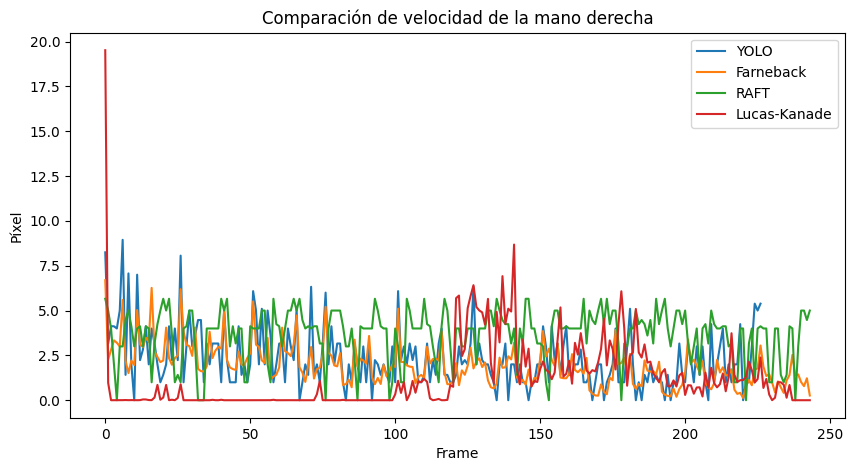

In [17]:
#crear gráfico de velocidades comparadas
plt.figure(figsize=(10, 5))
plt.plot(velocidad_yolo, label='YOLO')
plt.plot(velocidad_farneback, label='Farneback')
plt.plot(velocidad_raft, label='RAFT')
plt.plot(velocidad_lk, label='Lucas-Kanade')

plt.xlabel('Frame')
plt.ylabel('Píxel')
plt.title('Comparación de velocidad de la mano derecha')
plt.legend()
plt.show()

Las velocidades para los métodos de YOLO, Farneback y RAFT varían en un rango bajo entre 0 (sería cuando se pierde la mano en un frame) y 8. Lucas-Kanade sin embargo, al no funcionar correctamente presenta valles donde la velocidad es 0 y sufre una subida cuando detecta un punto debido a la ventana de influencia creada.

## Gráfica de Posición x

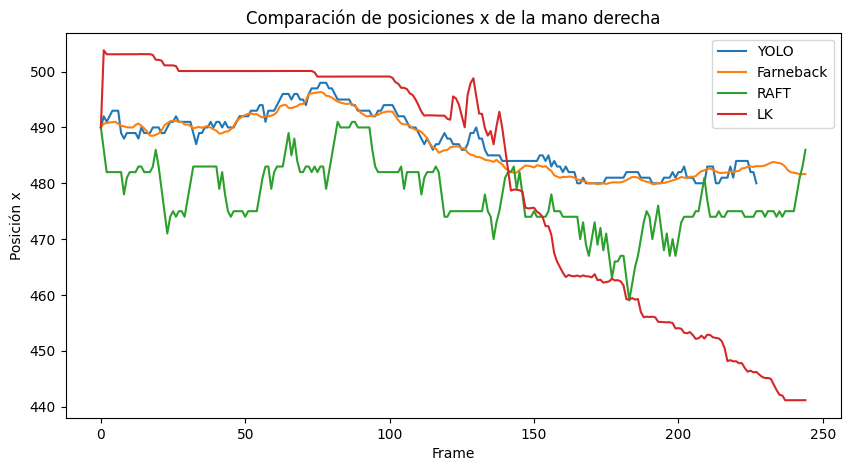

In [15]:
#crear gráfico de posiciones x comparadas
plt.figure(figsize=(10, 5))
plt.plot(x_yolo, label='YOLO')
plt.plot(x_farneback, label='Farneback')
plt.plot(x_raft, label='RAFT')
plt.plot(x_lk, label='LK')

plt.xlabel('Frame')
plt.ylabel('Posición x')
plt.legend()
plt.title('Comparación de posiciones x de la mano derecha')
plt.show()


En cuanto a la posición en x, esta se mantiene relativamente estable entre YOLO y Farneback, ya que ambos métodos son los que mejor logran detectar la mano. Por otro lado, Lucas-Kanade presenta un comportamiento de estabilidad aparente, ya que la posición se mantiene fija durante un período de tiempo. Sin embargo, esto se debe a que el método se traba en un punto y no detecta movimiento hasta que otra persona pasa por una posición cercana en x e y. Por lo tanto, podemos concluir que Lucas-Kanade no es efectivo para seguir el punto seleccionado. En cuanto a RAFT, los valores de x presentan una mayor variabilidad, ya que este método no siempre logra seguir la mano de manera precisa, sino que tiende a centrarse en el movimiento de la persona (debido a que hemos definido una ventana que busca flujos más grandes).

## Gráfica de Posición Y

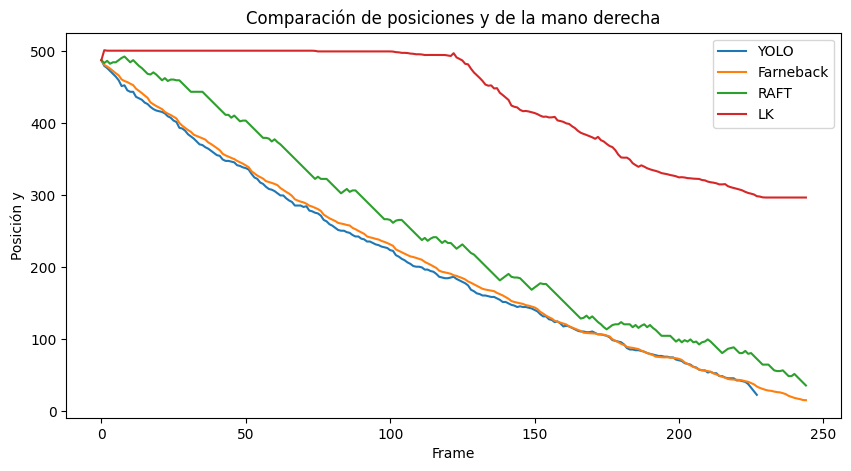

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(y_yolo, label='YOLO')
plt.plot(y_farneback, label='Farneback')
plt.plot(y_raft, label='RAFT')
plt.plot(y_lk, label='LK')

plt.xlabel('Frame')
plt.ylabel('Posición y')
plt.legend()
plt.title('Comparación de posiciones y de la mano derecha')
plt.show()

En cuanto a las posiciones en el eje y, la persona que estábamos siguiendo se mueve verticalmente desde la parte inferior hacia la parte superior de la imagen, lo que hace que el valor de y disminuya a medida que se acerca al borde superior. Farneback se ajusta muy bien a lo detectado por YOLO, lo que permite seguir de manera precisa el movimiento de la mano. RAFT, en cambio, no logra seguir la mano de manera consistente y tiende a rotar la predicción hacia diferentes partes del cuerpo, lo que genera una pequeña variación, aunque la tendencia general se mantiene. Por su parte, Lucas-Kanade no fue capaz de seguir el punto de estudio inicialmente, pero después de un par de frames, logra encontrar un flujo, aunque este corresponde a una persona diferente. Quizá si hubiéramos seguido otro punto, Lucas-Kanade habría funcionado correctamente.

## Conclusión

Los métodos que mejor siguen el movimiento de la mano son YOLO y Farneback, mientras que RAFT sigue con mayor precisión a la persona en su conjunto. Por otro lado, Lucas-Kanade tiene dificultades para seguir ciertos puntos, aunque es capaz de detectar el movimiento en otros casos.